Let's try to use mastrangelo to simulate a suite of planetary systems based on some galactic-driven prescription.

1. Choose some prescription in which systems younger than some threshold are more likely to have planets and systems older than that threshold are less likely to have planets, such that the total planet-host fraction of the sample is 40-50% (per Lam & Ballard 2024). This should depend on the two fractions I choose, as well as the location of the age threshold.

2. Using the Berger+ 2020 ages, assign planet fractions to the sample. Use Lam & Ballard 2024 intact fraction (4-13%) to determine how many planets each planet-hosting system gets.

3. Generate planetary systems for the sample.

4. Check the transit multiplicity. How does it compare to Kepler?

5. Check the planet occurrence rate with age. But we don't have anything to directly compare to, so...

6. Using ??? et al. age-galactic height relation, bootstrap using stellar age errors and try to check the planet occurrence with galactic height.

7. Profit.

In [88]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from glob import glob
import matplotlib.pyplot as plt
import scipy
from math import lgamma
import seaborn as sns
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from tqdm import tqdm

%matplotlib inline

path = '/Users/chrislam/Desktop/mastrangelo/'

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [97]:
#input_path = '/blue/sarahballard/c.lam/sculpting2/' # HPG
#output_path = '/blue/sarahballard/c.lam/sculpting2/mastrangelo/' # HPG
path = '/Users/chrislam/Desktop/mastrangelo/' # new computer has different username
berger_kepler = pd.read_csv(path+'data/berger_kepler_stellar_fgk.csv') # crossmatched with Gaia via Bedell

# make berger_kepler more wieldy
berger_kepler = berger_kepler[['kepid', 'iso_teff', 'iso_teff_err1', 'iso_teff_err2','feh_x','feh_err1','feh_err2',
						     'iso_age', 'iso_age_err1', 'iso_age_err2', 'iso_mass', 'iso_rad', 'rrmscdpp06p0',
							 'fractional_err1', 'logR', 'fractional_err2', 'is_giant']]
berger_kepler = berger_kepler.loc[berger_kepler.iso_age <= 14.]
print(len(berger_kepler))

#pnum = pd.read_csv(path+'data/pnum_plus_cands_fgk.csv') # planet hosts among crossmatched Berger sample
#k = pnum.groupby('kepid').count().koi_count.reset_index().groupby('koi_count').count()
k = pd.Series([833, 134, 38, 15, 5, 0])
G = 6.6743e-8 # gravitational constant in cgs

# how many params, how many dims, initialize cube
ndim = 3
nparams = 3
cube = [0, 0, 0]

66341


/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_91299/3641340934.py:4: DtypeWarning: Columns (138) have mixed types. Specify dtype option on import or set low_memory=False.
  berger_kepler = pd.read_csv(path+'data/berger_kepler_stellar_fgk.csv') # crossmatched with Gaia via Bedell


### Drawing scale height based on stellar age

Read in stellar density vs galactic height curves from Ma+ 2017 Fig 2: https://academic.oup.com/mnras/article/467/2/2430/2966031. I converted the image to data using PlotDigitizer.

In [166]:
data1 = pd.read_csv(path+'galactic-occurrence/data/Ma17-fig2-0-2Gyr.csv', header=None, 
                  names=['height','density'])
data2 = pd.read_csv(path+'galactic-occurrence/data/Ma17-fig2-2-4Gyr.csv', header=None, # Ma_midplaneheight_2Gyr_4Gyr.txt
                  names=['height','density'])
data3 = pd.read_csv(path+'galactic-occurrence/data/Ma17-fig2-4-6Gyr.csv', header=None, 
                  names=['height','density'])
data4 = pd.read_csv(path+'galactic-occurrence/data/Ma17-fig2-6-8Gyr.csv', header=None, 
                  names=['height','density'])
data5 = pd.read_csv(path+'galactic-occurrence/data/Ma17-fig2-8-moreGyr.csv', header=None, 
                  names=['height','density'])

Helper functions, copied from mastrangelo/src/ for now. 

In [168]:
def normalize(array):
    array = 10**array # exponentiate first!!
    sum = np.sum(array)
    return array/sum

def make_pdf_rows(x, mode, err1, err2):
    """
    Row-wise likelihood of asymmetric uncertainty, using Eqn 6 from https://iopscience.iop.org/article/10.3847/1538-3881/abd93f
    Less efficient, but row-wise in order to troubleshoot. 
    Takes in scalar values for mode, err1, and err2, not arrays.

    Input:
    - x: np.linspace(0.5, 14., 100); just something to undergird the PDF and represent stellar ages
    - mode: mean age; peak of asymmetric PDF
    - err1: + uncertainty
    - err2: - uncertainty (note: must be positive)

    Output:
    - pdf: asymmetric PDF

    """
    
    factor1 = 1/np.sqrt(2*np.pi*err1**2) 
    beta = err1/err2
    gamma = (err1 - np.abs(err2))/(err1 * np.abs(err2))
    
    factor2_arg_a = np.log(1+gamma*(x - mode))
    factor2_arg_b = np.log(beta)
    factor2_arg = factor2_arg_a/factor2_arg_b
    factor2 = np.exp(-0.5*(factor2_arg)**2)

    if np.isnan(factor1*factor2).all():
        print(mode, err1, err2)

    out = factor1 * factor2
    out[~np.isfinite(out)] = 0.0
    
    return out

def draw_star_ages(df):
    """
    Draw star's age, taking into account asymmetric age errors. Enriches input DataFrame.
    """

    # in case df is broken up by planet and not star
    uniques = df.drop_duplicates(subset=['kepid'])

    x = np.linspace(0.5, 14., 100)
    ages = np.ones(len(uniques))
    for i in range(len(uniques)):
        mode = uniques.iloc[i].iso_age
        err1 = uniques.iloc[i].iso_age_err1
        err2 = np.abs(uniques.iloc[i].iso_age_err2)

        # symmetric age uncertainties
        if err1==err2:
            age = 0
            while (age <= 0) | (age > 14.): # make sure the age is positive and realistic
                age = np.random.normal(mode, err1)

        # asymmetric uncertainties
        elif err1!=err2:
            pdf = make_pdf_rows(x, mode, err1, err2)
            pdf = pdf/np.sum(pdf)

            try:
                age = 0
                while (age <= 0) | (age > 14.): # make sure the age is positive and realistic
                    age = np.random.choice(x, p=pdf)
            except:
                print(i, pdf, mode, err1, err2)
                break
        
        ages[i] = age

    df['age'] = ages

    # break back out into planet rows and forward fill across systems
    df = uniques.merge(df, how='right')
    df['age'] = df.age.fillna(method='ffill')


    return df 


Is it fine to normalize to 1 and draw uniformly from there? It removes information about the stellar density, but if we're applying a real stellar sample with independently derived ages (as large as their errors may be) to these PDFs, that should be okay. I think.

Guess we'll try that first.

In [169]:
data1['density'] = normalize(data1['density']) 
data2['density'] = normalize(data2['density']) 
data3['density'] = normalize(data3['density']) 
data4['density'] = normalize(data4['density']) 
data5['density'] = normalize(data5['density']) 


Now we draw galactic height using the PDFs from Ma+ 2017.

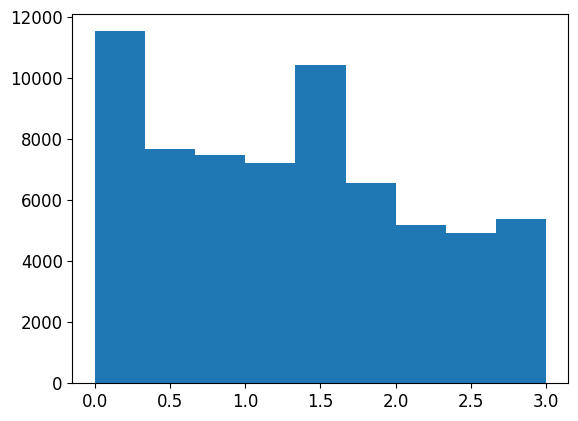

In [139]:
"""
heights = []
for i in range(len(berger_kepler_temp)):
    if berger_kepler_temp['age'][i] <= 2.:
        height = np.random.choice(data1['height'], p=data1['density'])
    elif (berger_kepler_temp['age'][i] > 2.) & (berger_kepler_temp['age'][i] <= 4.):
        height = np.random.choice(data2['height'], p=data2['density'])
    elif (berger_kepler_temp['age'][i] > 4.) & (berger_kepler_temp['age'][i] <= 6.):
        height = np.random.choice(data3['height'], p=data3['density'])
    elif (berger_kepler_temp['age'][i] > 6.) & (berger_kepler_temp['age'][i] <= 8.):
        height = np.random.choice(data4['height'], p=data4['density'])
    elif berger_kepler_temp['age'][i] > 8.:
        height = np.random.choice(data5['height'], p=data5['density'])
    heights.append(height)

plt.hist(heights, bins=np.linspace(0, 3, 10))
plt.show()
"""

[0.         0.59247649 2.54858934 2.69905956]


(array([10943., 30782.,     0.,     0.,     0.,     0.,     0., 13573.,
        11043.]),
 array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ]),
 <BarContainer object of 9 artists>)

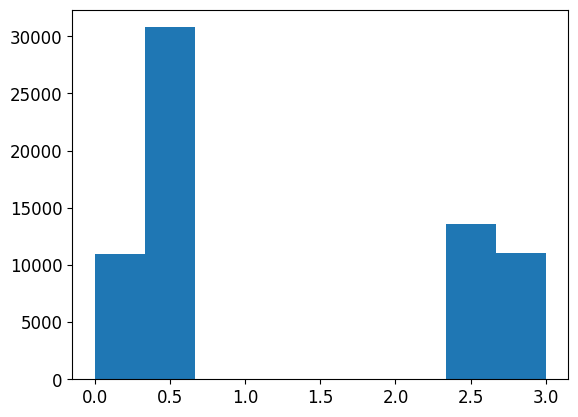

In [143]:
"""
def draw_height(df):
    return np.random.choice(df['height'], p=df['density'])
    
heights = np.where(berger_kepler_temp['age'] <= 2., draw_height(data1),
                  np.where(berger_kepler_temp['age'] <= 4., draw_height(data2), 
                           np.where(berger_kepler_temp['age'] <= 6., draw_height(data3),
                                     np.where(berger_kepler_temp['age'] <= 8., draw_height(data4), draw_height(data5)))))
plt.hist(heights, bins=np.linspace(0, 3, 10))
"""

In [171]:
heights_all = []
for j in tqdm(range(10)):
    
    # redraw stellar ages based on asymmetric errors
    berger_kepler_temp = draw_star_ages(berger_kepler)

    # draw heights based on stellar ages
    """
    heights = np.where(berger_kepler_temp['age'] <= 2., np.random.choice(data1['height'], p=data1['density']),
                  np.where(berger_kepler_temp['age'] <= 4., np.random.choice(data2['height'], p=data2['density']), 
                           np.where(berger_kepler_temp['age'] <= 6., np.random.choice(data3['height'], p=data3['density']),
                                     np.where(berger_kepler_temp['age'] <= 8., np.random.choice(data4['height'], p=data4['density']),
                                              np.random.choice(data5['height'], p=data5['density'])))))
    """
    heights = []
    for i in range(len(berger_kepler_temp)):
        if berger_kepler_temp['age'][i] <= 2.:
            height = np.random.choice(data1['height'], p=data1['density'])
        elif (berger_kepler_temp['age'][i] > 2.) & (berger_kepler_temp['age'][i] <= 4.):
            height = np.random.choice(data2['height'], p=data2['density'])
        elif (berger_kepler_temp['age'][i] > 4.) & (berger_kepler_temp['age'][i] <= 6.):
            height = np.random.choice(data3['height'], p=data3['density'])
        elif (berger_kepler_temp['age'][i] > 6.) & (berger_kepler_temp['age'][i] <= 8.):
            height = np.random.choice(data4['height'], p=data4['density'])
        elif berger_kepler_temp['age'][i] > 8.:
            height = np.random.choice(data5['height'], p=data5['density'])
        heights.append(height)
        
    heights_all.append(heights)


  0%|                                                                                                                                                          | 0/10 [00:00<?, ?it/s]/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_91299/1453859283.py:27: RuntimeWarning: invalid value encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_91299/1453859283.py:27: RuntimeWarning: divide by zero encountered in log
  factor2_arg_a = np.log(1+gamma*(x - mode))
/var/folders/tt/rlpbr2fs7lx14h3f5_21mr240000gn/T/ipykernel_91299/1453859283.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['age'] = df.age.fillna(method='ffill')
 10%|██████████████▌                                                                                                                                   | 1/10 [00:06<01:01,  6.84s/it]/var/folders/tt/rlpbr

In [172]:
heights_all_median = np.median(np.array(heights_all), axis=0)
heights_all_mean = np.mean(np.array(heights_all), axis=0)

(array([22046., 11718.,  8767.,  6390.,  6646.,  3463.,  2562.,  2108.,
         2641.]),
 array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
        1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ]),
 <BarContainer object of 9 artists>)

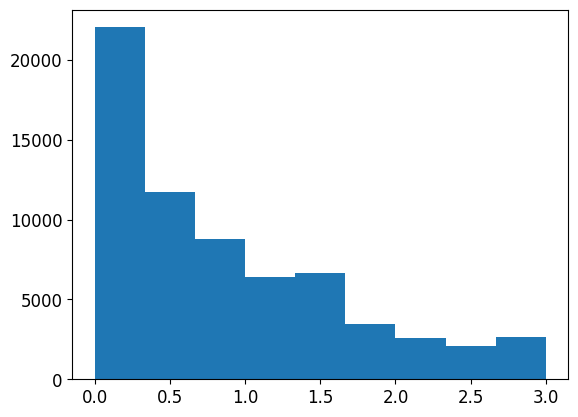

In [173]:
plt.hist(heights, bins=np.linspace(0, 3, 10))

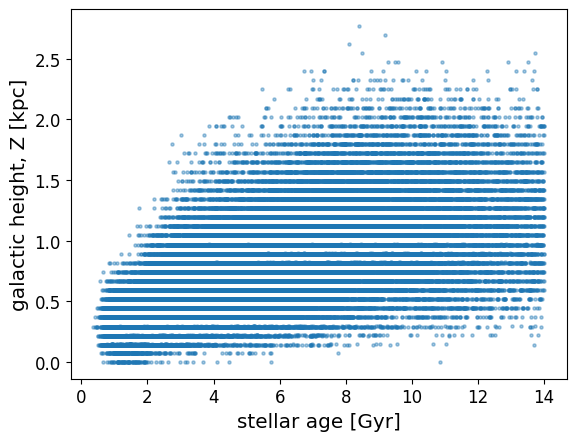

In [176]:
plt.scatter(berger_kepler.iso_age, heights_all_median, alpha=0.4, s=5)
plt.ylabel('galactic height, Z [kpc]')
plt.xlabel('stellar age [Gyr]')
plt.show()

Two things: 1) ew; let's try to draw our galactic heights using a more continuous distribution; and 2) let's try Sarah's vision of color-coding by age, with the x-axis being meaningless.

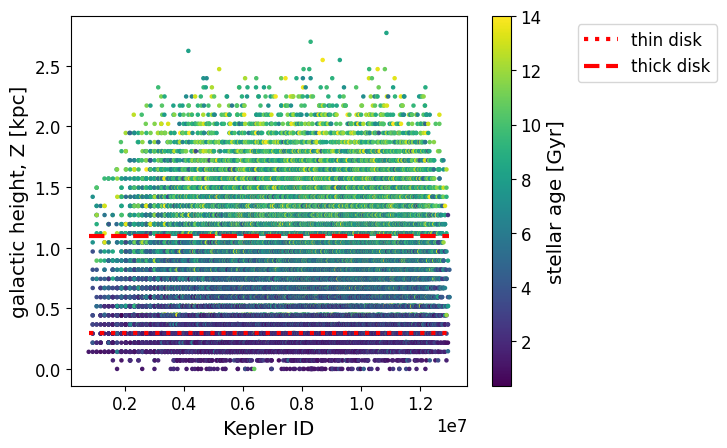

In [181]:
plt.scatter(berger_kepler.kepid, heights_all_median, c=berger_kepler.iso_age, s=5, alpha=1.)

plt.hlines(0.3, min(berger_kepler.kepid), max(berger_kepler.kepid), linestyle='dotted', color='r', label='thin disk', linewidth=3)
plt.hlines(1.1, min(berger_kepler.kepid), max(berger_kepler.kepid), linestyle='dashed', color='r', label='thick disk', linewidth=3)

plt.ylabel('galactic height, Z [kpc]')
plt.xlabel('Kepler ID')
plt.colorbar(label='stellar age [Gyr]')

plt.legend(bbox_to_anchor=(1.65, 1.0))
plt.show()

### Drawing planet ocurrence based on stellar age

In [ ]:
zink_kepler = pd.DataFrame()
zink_k2 = pd.DataFrame()

4-13% of Kepler systems being STIPs and 40-50% of Kepler systems hosting planets means that among planet hosts, 8-33% of planet hosts are compact multis. So, let's use this figure for now to paint on planets. 

In [ ]:
f1 = 0.2
f2 = 0.6
threshold = 3.

multiplicities = []
for i in range(len(berger_kepler)):
    multiplicity = 